📂 이미지 폴더 스캔 중...
   -> 매핑된 이미지 수: 800
📊 JSON 데이터 분석 시작 (800개)...


100%|██████████| 800/800 [00:43<00:00, 18.43it/s]


📑 엑셀 메타데이터 로드 중...
   -> 정제 전 성별 값(샘플): ['_x0008_여' '_x0008_남' '남' '여' ' 여']
   -> 정제 후 성별 값(샘플): ['Female' 'Male']


,subject_id,Total_Bone_Area,Bone_Density,Bone_Spread,Age,Sex,Weight,Height
0,001,450340.5,143.813080,478.844385,30,Female,63.0,165.0
1,001,438925.0,142.135406,465.741683,30,Female,63.0,165.0
2,002,520145.0,118.512243,472.022959,21,Male,70.0,172.0
3,002,510587.5,117.230442,462.502853,21,Male,70.0,172.0
4,003,387600.0,123.107676,441.979796,21,Female,48.0,164.0


/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEON

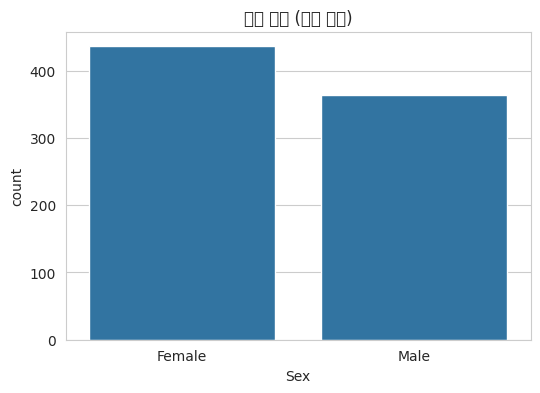

In [23]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import platform
from matplotlib import font_manager, rc

# =========================================================
# 1. 시각화 및 한글 폰트 설정
# =========================================================
%matplotlib inline

def set_korean_font():
    system_name = platform.system()
    if system_name == 'Darwin':
        rc('font', family='AppleGothic')
    elif system_name == 'Windows':
        rc('font', family='Malgun Gothic')
    else:
        fonts = [f.name for f in font_manager.fontManager.ttflist if 'Nanum' in f.name]
        if fonts:
            rc('font', family=fonts[0])
        else:
            rc('font', family='sans-serif')
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

# =========================================================
# 2. 경로 설정
# =========================================================
DATA_ROOT = '/data/ephemeral/home/data'
IMAGE_ROOT_DIR = os.path.join(DATA_ROOT, 'train/DCM') 
META_PATH = os.path.join(DATA_ROOT, 'meta_data.xlsx')

# =========================================================
# 3. [핵심 수정] 성별 데이터 정제 함수 (특수문자 제거)
# =========================================================
def clean_sex_column(x):
    if pd.isna(x):
        return 'Unknown'
    
    # 1. 문자열로 변환
    x = str(x)
    
    # 2. 문제의 특수문자(_x0008_) 및 공백 제거
    x = x.replace('_x0008_', '').strip()
    
    # 3. 포함 여부로 판단 (더 강력한 조건)
    if '남' in x or 'M' in x.upper():
        return 'Male'
    elif '여' in x or 'F' in x.upper():
        return 'Female'
    else:
        return 'Unknown'

# =========================================================
# 4. 데이터 로드 및 분석 메인 로직
# =========================================================
def load_and_analyze_data():
    # --- Step A: 이미지 ID 매핑 ---
    print("📂 이미지 폴더 스캔 중...")
    image_paths = glob(os.path.join(IMAGE_ROOT_DIR, '**/*.png'), recursive=True)
    
    file_to_id = {}
    file_to_path = {}
    
    for path in image_paths:
        folder_name = os.path.basename(os.path.dirname(path))
        # ID 추출: 숫자만 남기고 3자리로 (예: ID01 -> 001)
        clean_id = ''.join(filter(str.isdigit, folder_name)).zfill(3)
        filename = os.path.basename(path)
        file_to_id[filename] = clean_id
        file_to_path[filename] = path

    print(f"   -> 매핑된 이미지 수: {len(file_to_id)}")

    # --- Step B: JSON 분석 ---
    json_paths = sorted(glob(os.path.join(DATA_ROOT, '**/*.json'), recursive=True))
    json_paths = [p for p in json_paths if 'output' in p or 'train' in p]
    
    print(f"📊 JSON 데이터 분석 시작 ({len(json_paths)}개)...")
    
    meta_list = []
    
    if len(json_paths) > 0:
        for json_path in tqdm(json_paths):
            try:
                with open(json_path, "r") as f:
                    data = json.load(f)
                
                filename = os.path.basename(json_path).replace('.json', '.png')
                if filename not in file_to_id:
                    continue
                    
                subject_id = file_to_id[filename]
                img_path = file_to_path[filename]
                
                # 특징 추출
                mean_intensity = np.nan
                spread_diag = np.nan
                total_area = 0
                annotations = data.get('annotations', [])
                centroids = []
                
                for ann in annotations:
                    points = np.array(ann['points'])
                    total_area += cv2.contourArea(points)
                    M = cv2.moments(points)
                    if M["m00"] != 0:
                        centroids.append([int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])])
                
                if img_path and os.path.exists(img_path) and annotations:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mask = np.zeros_like(img, dtype=np.uint8)
                    for ann in annotations:
                        cv2.fillPoly(mask, [np.array(ann['points'])], 1)
                    if np.sum(mask) > 0:
                        mean_intensity = cv2.mean(img, mask=mask)[0]
                    if len(centroids) > 1:
                        pts = np.array(centroids)
                        spread_diag = np.sqrt(np.std(pts[:, 0])**2 + np.std(pts[:, 1])**2)

                meta_list.append({
                    'subject_id': subject_id,
                    'Total_Bone_Area': total_area,
                    'Bone_Density': mean_intensity,
                    'Bone_Spread': spread_diag
                })
            except:
                continue

    json_df = pd.DataFrame(meta_list)
    
    # --- Step C: 엑셀 메타데이터 병합 ---
    if os.path.exists(META_PATH):
        print("\n📑 엑셀 메타데이터 로드 중...")
        try:
            meta_df = pd.read_excel(META_PATH)
        except:
            # 엑셀 로드 실패시 CSV로 시도 (csv일 가능성 고려)
            try:
                meta_df = pd.read_csv(META_PATH)
            except:
                print("❌ 파일을 읽을 수 없습니다.")
                return json_df

        # [수정] Unnamed: ... 같은 쓸모없는 빈 컬럼 삭제
        meta_df = meta_df.loc[:, ~meta_df.columns.str.contains('^Unnamed')]

        # 컬럼명 정리
        meta_df.columns = meta_df.columns.str.strip()
        rename_map = {'ID':'subject_id', '나이':'Age', '성별':'Sex', '키(신장)':'Height', '체중(몸무게)':'Weight'}
        meta_df = meta_df.rename(columns=rename_map)
        
        # ID 없으면 첫번째 컬럼 사용
        if 'subject_id' not in meta_df.columns:
            meta_df = meta_df.rename(columns={meta_df.columns[0]: 'subject_id'})
        
        # ID 포맷 통일 ('1' -> '001')
        meta_df['subject_id'] = meta_df['subject_id'].astype(str).apply(lambda x: ''.join(filter(str.isdigit, x)).zfill(3))
        
        # [핵심] 성별 컬럼 정제 적용
        if 'Sex' in meta_df.columns:
            print(f"   -> 정제 전 성별 값(샘플): {meta_df['Sex'].unique()[:5]}")
            meta_df['Sex'] = meta_df['Sex'].apply(clean_sex_column)
            print(f"   -> 정제 후 성별 값(샘플): {meta_df['Sex'].unique()}")
        
        # 병합
        final_df = pd.merge(json_df, meta_df, on='subject_id', how='inner')
        
        # 수치형 변환
        cols = ['Age', 'Height', 'Weight', 'Total_Bone_Area', 'Bone_Density', 'Bone_Spread']
        for c in cols:
            if c in final_df.columns:
                final_df[c] = pd.to_numeric(final_df[c], errors='coerce')

        return final_df

    else:
        print("❌ 메타데이터 파일을 찾을 수 없습니다.")
        return json_df

# 실행
df = load_and_analyze_data()

if not df.empty:
    display(df.head()) # 결과 확인
    
    # 성별 분포 시각화
    if 'Sex' in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='Sex', data=df)
        plt.title('성별 분포 (정제 완료)')
        plt.show()
else:
    print("데이터프레임이 비어있습니다.")

/tmp/ipykernel_621398/117803910.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=df, ax=axes[0], palette='Set2')


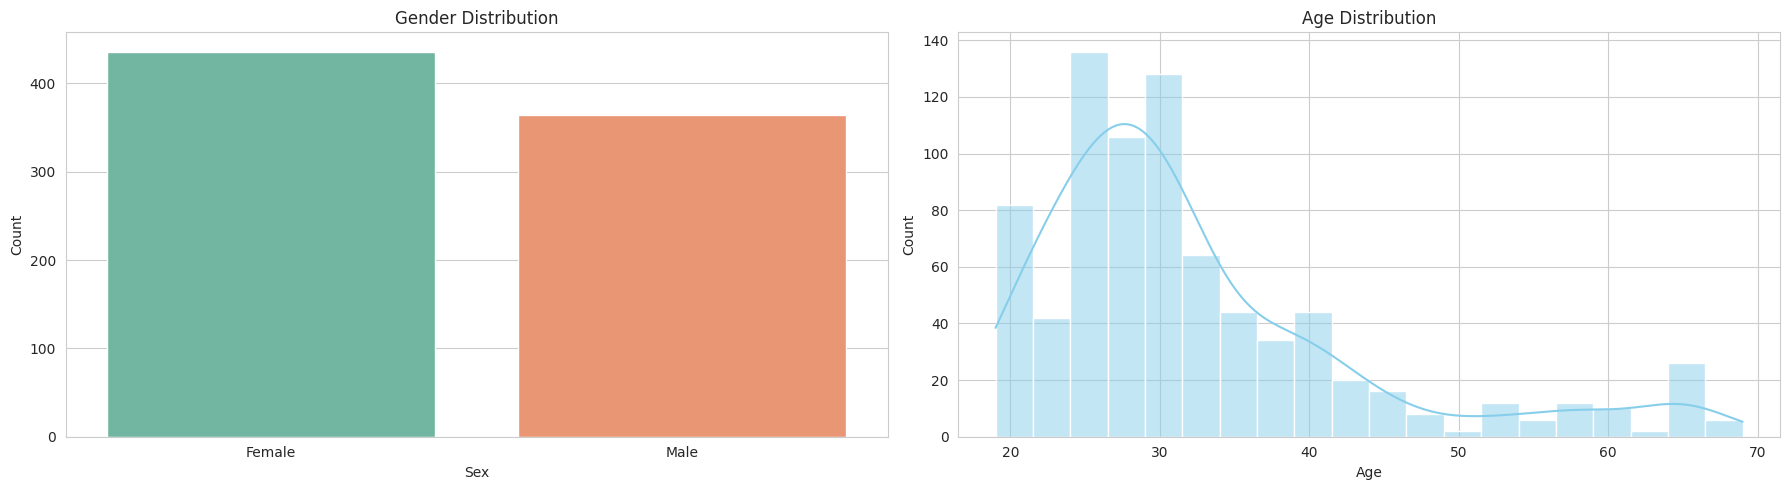

In [24]:
# 1. 화면 분할 설정
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# A. 성별 분포 (Count Plot)
sns.countplot(x='Sex', data=df, ax=axes[0], palette='Set2')
axes[0].set_title("Gender Distribution")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")

# B. 나이 분포 (Histogram)
sns.histplot(data=df, x='Age', bins=20, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title("Age Distribution")


plt.tight_layout()
plt.show()

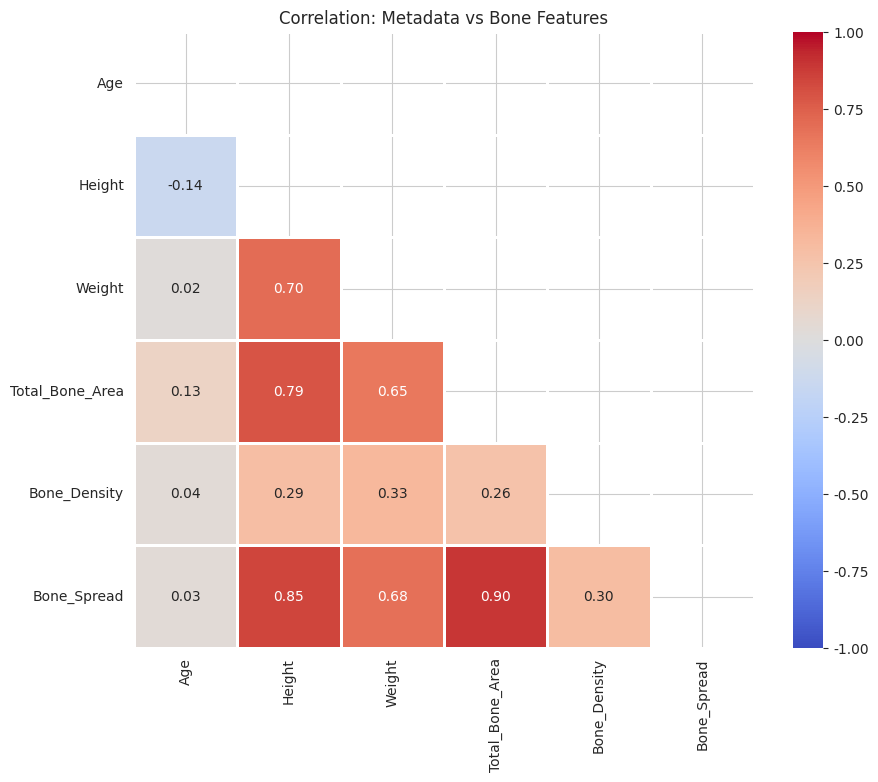

In [25]:
plt.figure(figsize=(10, 8))

# 분석할 컬럼들
target_cols = ['Age', 'Height', 'Weight', 'Total_Bone_Area', 'Bone_Density', 'Bone_Spread']
valid_cols = [c for c in target_cols if c in df.columns]

# 상관계수
corr = df[valid_cols].corr()

# 히트맵
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, vmin=-1, vmax=1, linewidths=1)
plt.title("Correlation: Metadata vs Bone Features")
plt.show()

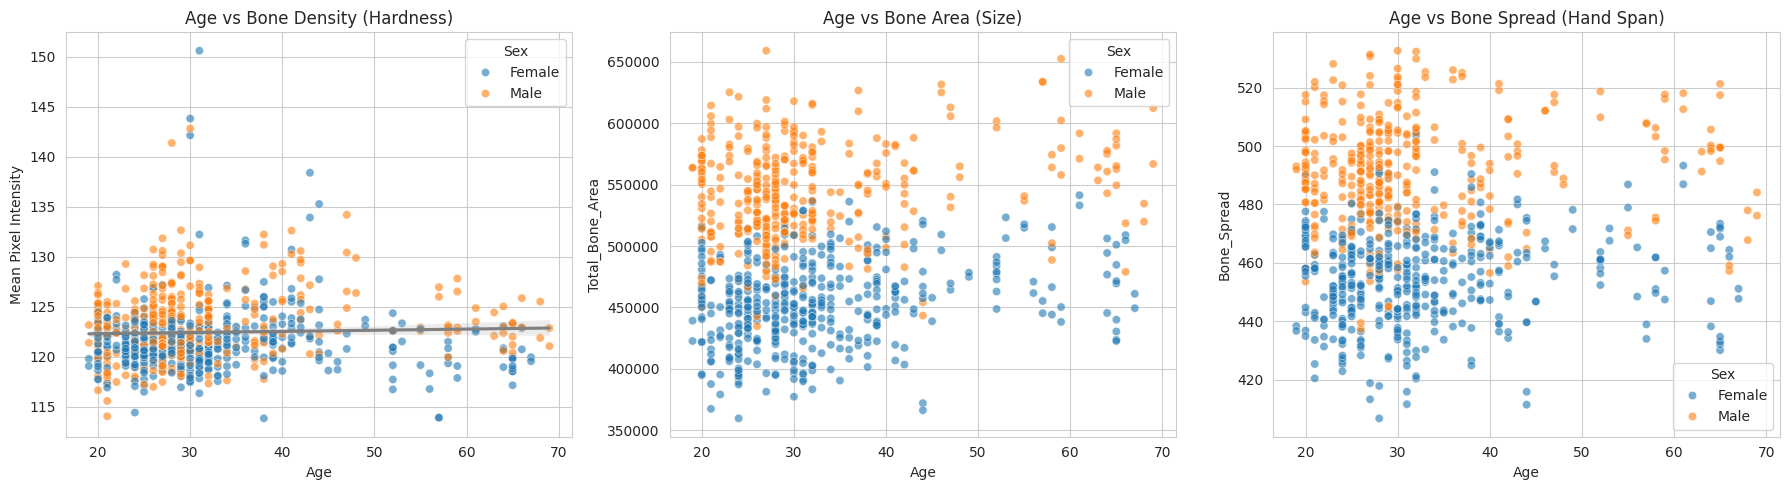

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. 나이 vs 뼈 밀도 (단단함)
sns.scatterplot(x='Age', y='Bone_Density', hue='Sex', data=df, ax=ax[0], alpha=0.6)
sns.regplot(x='Age', y='Bone_Density', data=df, scatter=False, ax=ax[0], color='gray')
ax[0].set_title("Age vs Bone Density (Hardness)")
ax[0].set_ylabel("Mean Pixel Intensity")

# 2. 나이 vs 뼈 면적 (크기)
sns.scatterplot(x='Age', y='Total_Bone_Area', hue='Sex', data=df, ax=ax[1], alpha=0.6)
ax[1].set_title("Age vs Bone Area (Size)")

# 3. 나이 vs 뼈 분포 (손 크기)
sns.scatterplot(x='Age', y='Bone_Spread', hue='Sex', data=df, ax=ax[2], alpha=0.6)
ax[2].set_title("Age vs Bone Spread (Hand Span)")

plt.tight_layout()
plt.show()

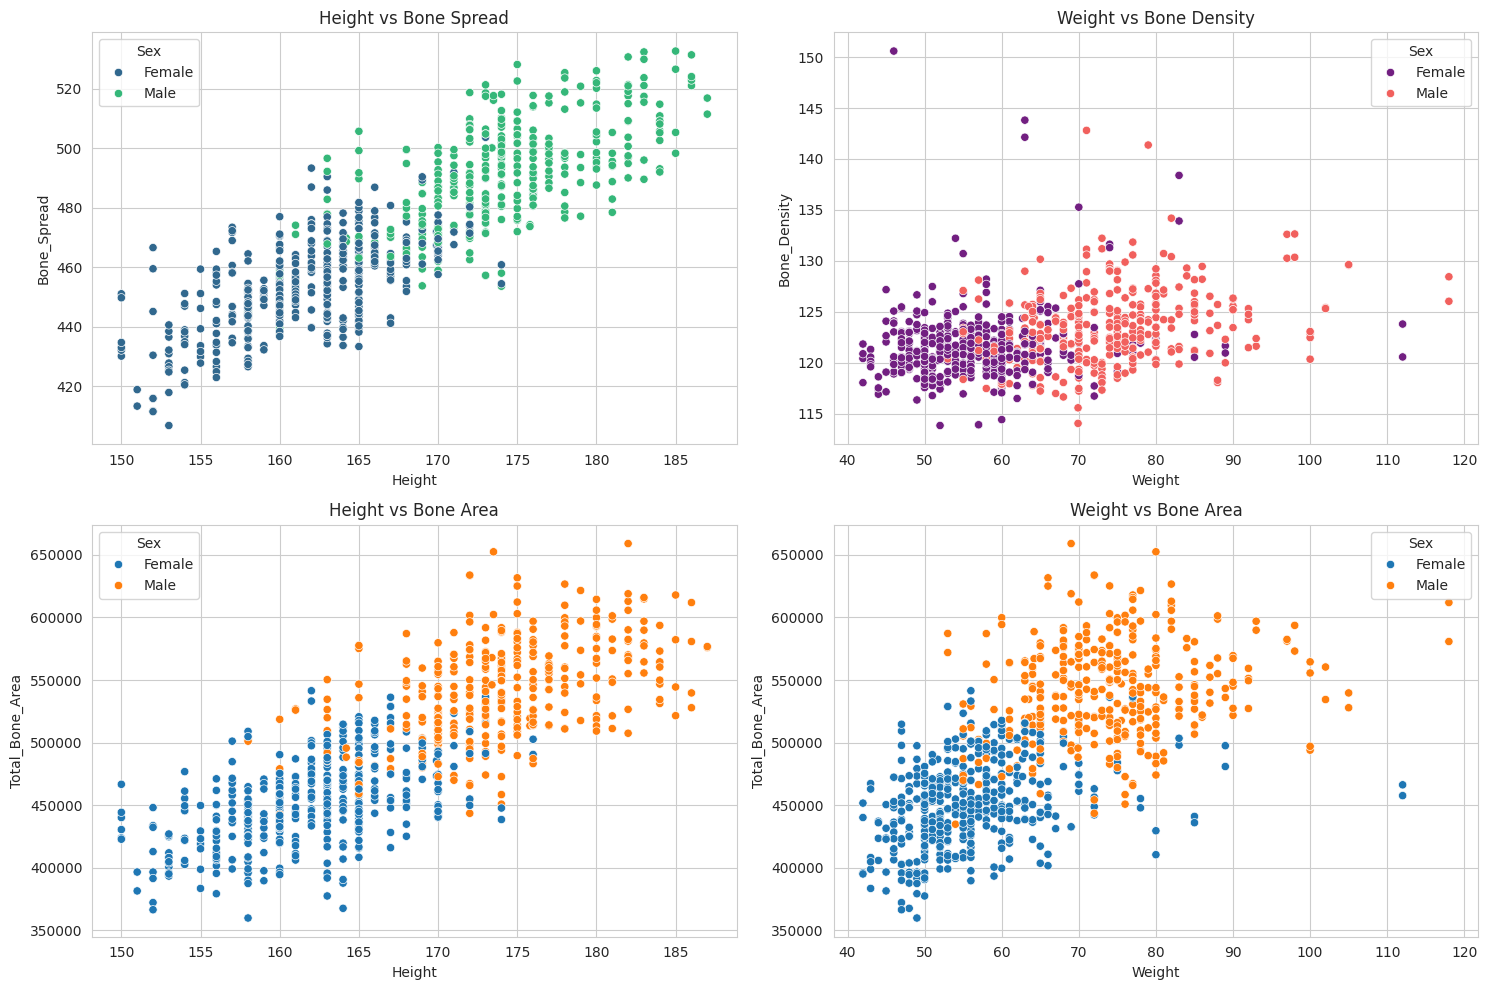

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

if 'Height' in df.columns and 'Weight' in df.columns:
    # 1. 키 vs 뼈 분포 (키가 크면 손도 넓게 펴져있나?)
    sns.scatterplot(x='Height', y='Bone_Spread', hue='Sex', data=df, ax=ax[0,0], palette='viridis')
    ax[0,0].set_title("Height vs Bone Spread")
    
    # 2. 몸무게 vs 뼈 밀도 (체중이 많이 나가면 뼈가 더 단단한가?)
    sns.scatterplot(x='Weight', y='Bone_Density', hue='Sex', data=df, ax=ax[0,1], palette='magma')
    ax[0,1].set_title("Weight vs Bone Density")
    
    # 3. 키 vs 뼈 면적
    sns.scatterplot(x='Height', y='Total_Bone_Area', hue='Sex', data=df, ax=ax[1,0])
    ax[1,0].set_title("Height vs Bone Area")

    # 4. 몸무게 vs 뼈 면적
    sns.scatterplot(x='Weight', y='Total_Bone_Area', hue='Sex', data=df, ax=ax[1,1])
    ax[1,1].set_title("Weight vs Bone Area")

    plt.tight_layout()
    plt.show()
else:
    print("키/몸무게 데이터가 없습니다.")

/tmp/ipykernel_621398/1500173058.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sex', y='Bone_Density', data=df, ax=ax[0], palette='muted')
/tmp/ipykernel_621398/1500173058.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sex', y='Total_Bone_Area', data=df, ax=ax[1], palette='pastel')
/tmp/ipykernel_621398/1500173058.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sex', y='Bone_Spread', data=df, ax=ax[2], palette='Set2')


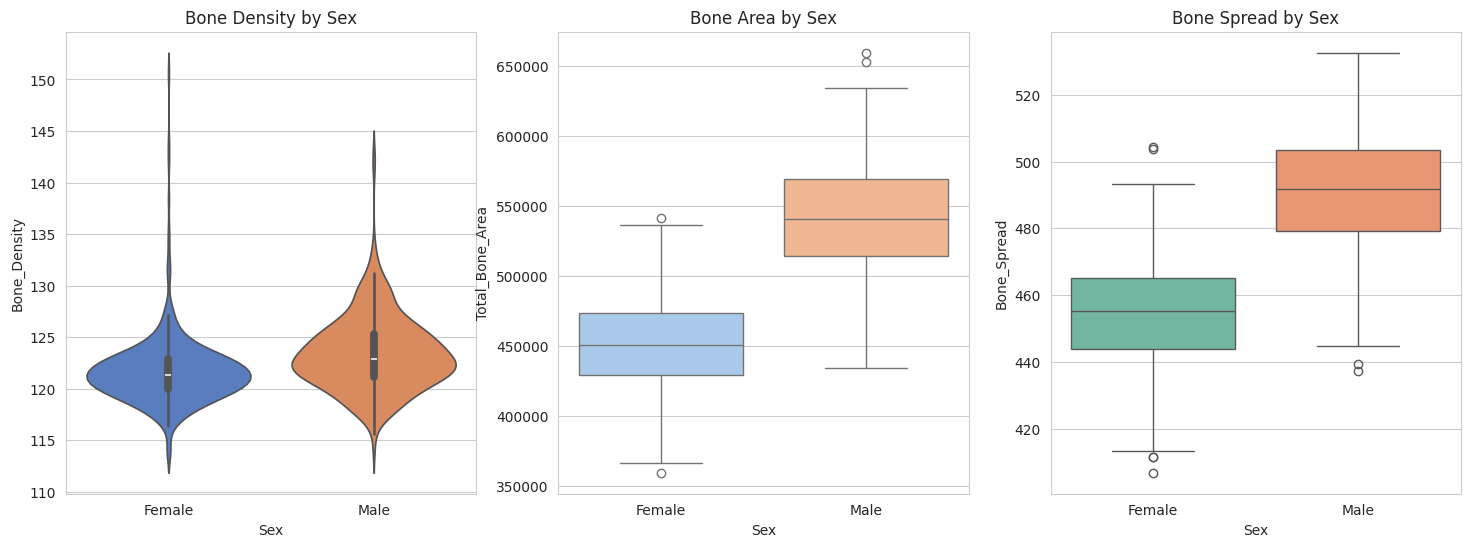

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. 성별에 따른 밀도 차이
sns.violinplot(x='Sex', y='Bone_Density', data=df, ax=ax[0], palette='muted')
ax[0].set_title("Bone Density by Sex")

# 2. 성별에 따른 면적 차이
sns.boxplot(x='Sex', y='Total_Bone_Area', data=df, ax=ax[1], palette='pastel')
ax[1].set_title("Bone Area by Sex")

# 3. 성별에 따른 분포(손 크기) 차이
sns.boxplot(x='Sex', y='Bone_Spread', data=df, ax=ax[2], palette='Set2')
ax[2].set_title("Bone Spread by Sex")

plt.show()

## 기초 통계량 (Descriptive Statistics) ##


,Total_Bone_Area,Bone_Density,Bone_Spread
count,800.000000,800.000000,800.000000
mean,493060.005000,122.449774,471.235759
std,57809.339041,3.589202,24.968445
min,359689.000000,113.848649,406.748737
25%,447871.750000,120.291698,452.386685
50%,489273.000000,121.935921,469.084710
75%,536250.000000,123.899345,490.363678
max,659132.000000,150.591554,532.653365


--------------------------------------------------


/tmp/ipykernel_621398/3515442845.py:31: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_621398/3515442845.py:31: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


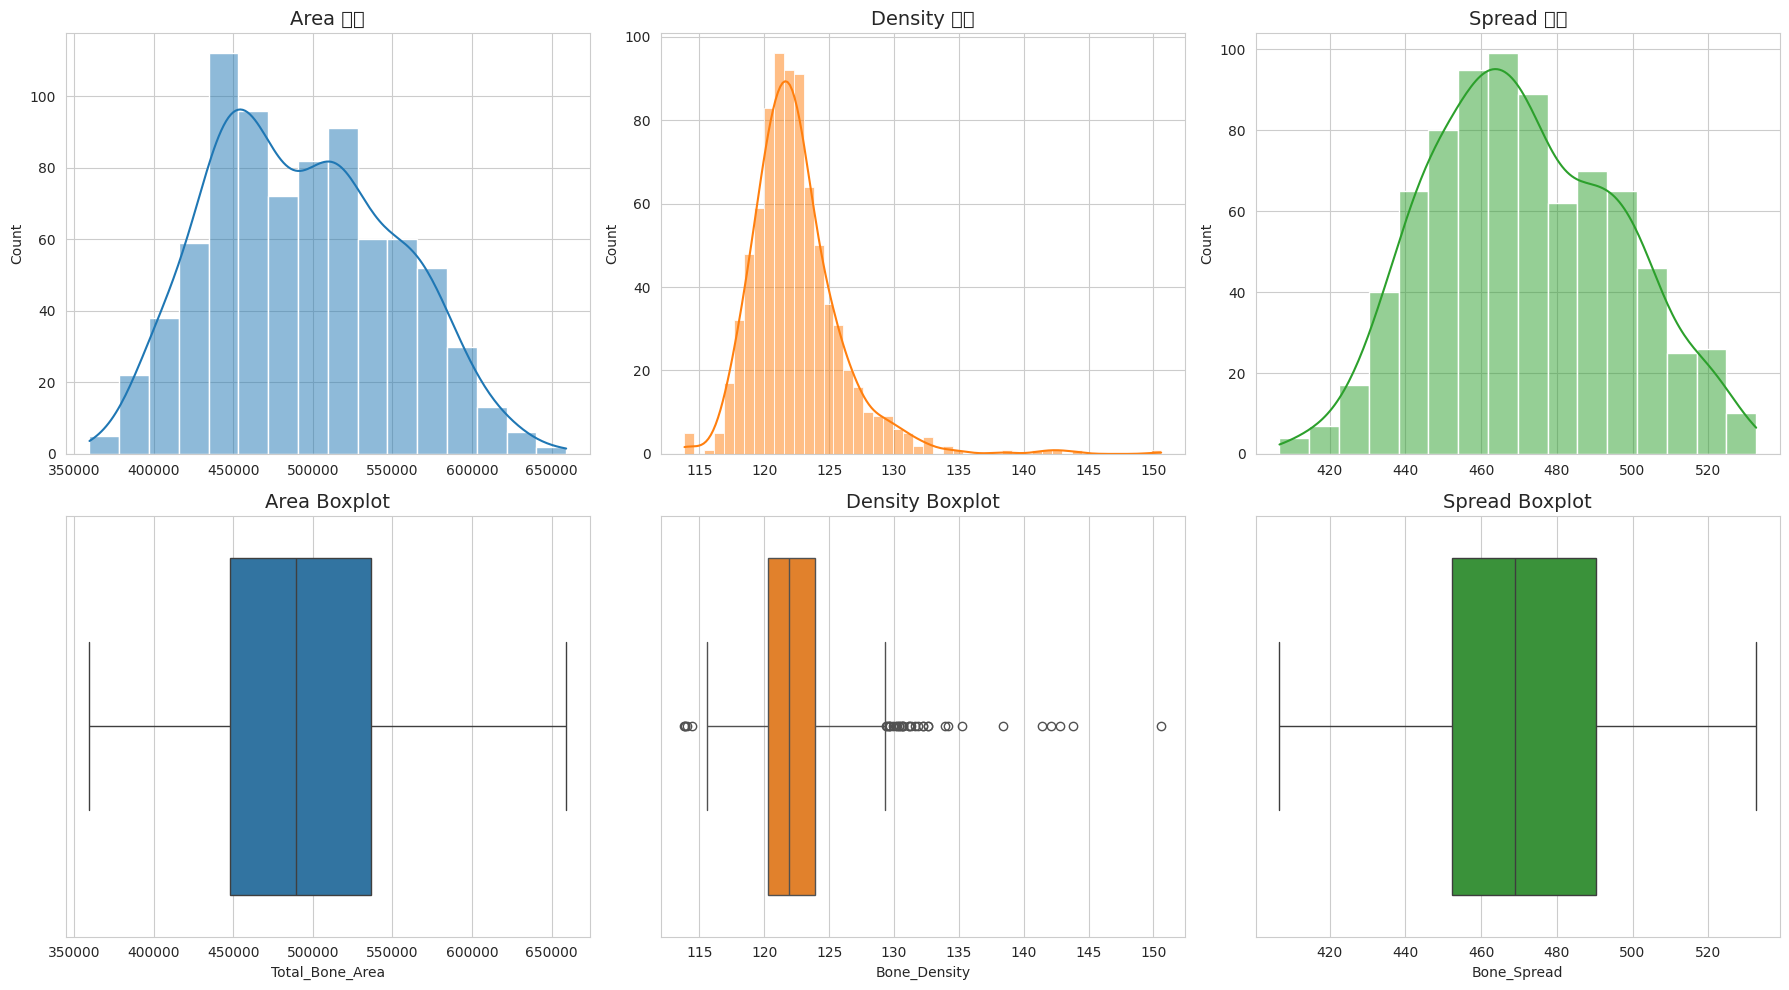

/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51669 (\N{HANGUL SYLLABLE JING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN

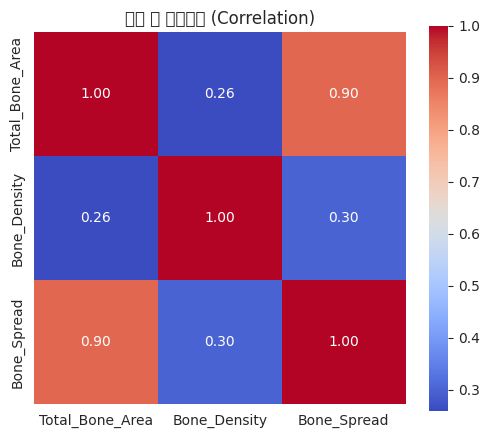

In [31]:
# =========================================================
# 이미지 추출 특징(Feature) 분포 시각화
# =========================================================

# 1. 분석할 컬럼 정의
feature_cols = ['Total_Bone_Area', 'Bone_Density', 'Bone_Spread']

# 2. 기초 통계량 출력
print("## 기초 통계량 (Descriptive Statistics) ##")
display(df[feature_cols].describe())
print("-" * 50)

# 3. 시각화 (히스토그램 + 박스플롯)
# 데이터가 존재하는지 확인
if not df.empty and all(col in df.columns for col in feature_cols):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    titles = ['Area', 'Density', 'Spread']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 파랑, 주황, 초록

    for i, col in enumerate(feature_cols):
        # (1) 히스토그램 (분포 모양)
        sns.histplot(df[col], kde=True, ax=axes[0, i], color=colors[i])
        axes[0, i].set_title(f'{titles[i]} 분포', fontsize=14)
        axes[0, i].set_xlabel('')
        
        # (2) 박스플롯 (이상치 확인)
        sns.boxplot(x=df[col], ax=axes[1, i], color=colors[i])
        axes[1, i].set_title(f'{titles[i]} Boxplot', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 4. 상관관계 (특징끼리 관계가 있는지)
    plt.figure(figsize=(6, 5))
    sns.heatmap(df[feature_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('특징 간 상관관계 (Correlation)')
    plt.show()
    
else:
    print("⚠️ 데이터프레임이 비어있거나 필요한 컬럼이 없습니다.")